In [193]:
import numpy as np
import pandas as p
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
import tensorflow_probability as tfp


In [68]:
# GET THE MNIST DATA
(x_train, y_test), (x_test, y_test) = mnist.load_data()


In [14]:
# Function to 
# 1. Change dimensions
# 2. Change datatype
def binary_preprocess(imageset):
    imageset = imageset.reshape(imageset.shape[0],28,28,1)/255.
    return np.where(imageset > .5, 1.0,0.0).astype('float32')

In [15]:
# Pre-processed images 
x_train_images = binary_preprocess(x_train)
x_test_images = binary_preprocess(x_test)

In [9]:
# Dataset object to get a mini-batch
batch_size = 100
train_size = x_train_images.shape[0]

In [3]:
def get_encoder():
  # THE ENCODER DEFINITION
    encoded = tf.keras.models.Sequential(
          [
            tf.keras.layers.InputLayer(input_shape=(28,28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128,activation='relu'),
            tf.keras.layers.Dense(32,activation='relu'),              
            # No activation
            tf.keras.layers.Dense(4),
        ]
    )
    return encoded


# Sequential API decoder

def get_decoder():
    decoded = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),              
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),            
            tf.keras.layers.Dense(784),
            tf.keras.layers.Reshape((28,28,1))
        ]
    )

    return decoded


In [236]:
# Encoding step
# Get the mean and the variance
def encode(encoder,x):
    activations = encoder(x)
    mean, variance = tf.split(activations,num_or_size_splits=2,axis=1)
    return mean,variance

# Reparametrization step
def sample(mu, logvar):
    
    e = tf.random.normal(shape=mu.shape)
    return e * tf.exp(logvar/2) + mu

# Combine the autoencoder
def autoencoder(encoder,decoder,x):
    mean,logvariance = encode(encoder,x)
    z = sample(mean,logvariance)
    output = decoder(z)
    return output

In [237]:
new_encoder = get_encoder()
new_encoder.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 1028      
Total params: 201,988
Trainable params: 201,988
Non-trainable params: 0
_________________________________________________________________


In [246]:
mean,logvariance = encode(new_encoder,x_train_images[0:10])
z = sample(mean,logvariance)
z

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.25418028, -1.2459699 ],
       [ 0.06401986,  0.23973823],
       [ 1.4027771 ,  0.37094837],
       [ 0.30310908, -1.8395888 ],
       [-0.67487675,  0.23556402],
       [ 0.10179734, -0.5165427 ],
       [-0.07980438, -0.99448824],
       [-0.65047574,  1.0163721 ],
       [ 0.08244508, -1.9401627 ],
       [-0.9747116 ,  0.23947018]], dtype=float32)>

## KL Divergence Analytical form

$\mathrm{KL} [ q_{\phi}(\mathbf{z} | \mathbf{x}) || p(\mathbf{z}) ]
= - \frac{1}{2} \sum_{k=1}^K { 1 + \log \sigma_k^2 - \mu_k^2 - \sigma_k^2 }$

In [57]:
# Quick way to get the log likelihood of a normal distribution
def log_normal_pdf(value, mean, logvar, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    logpdf = -(logvar + log_2pi + (value - mean)**2. * tf.exp(-logvar))/2
    return tf.reduce_sum(logpdf,axis=1)

# Loss over the assumed distribution(qz_x) and the prior(pz)
def kl_loss(encoder, x):
    mean, logvar = encode(encoder,x)
    z = sample(mean,logvar)
    # prior distribution
    logpz = log_normal_pdf(z, 0., 0.)
    # Assumed variational distribution
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return tf.reduce_mean(logqz_x - logpz)

def analytical_kl(encoder,x):
    mean, logvar = encode(encoder,x)
    lossval = tf.reduce_sum(-0.5*(1 + logvar - tf.square(mean) - tf.exp(logvar)),axis=-1)
    return tf.reduce_mean(lossval)

# This is now binary cross entropy
# Crucially, observe that we sum across the image dimensions
# and only take the mean in the images dimension
def reconstruction_loss(encoder,decoder,x):
    x_logits = autoencoder(encoder,decoder,x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits,labels=x)
    return tf.reduce_mean(tf.reduce_sum(loss,axis=[1,2,3]))

In [233]:
x = tf.Variable(2.0)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>

In [234]:
with tf.GradientTape() as tape:
    y = x ** 2  # Gradients will be available for `x`.
    

In [235]:
dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(4.0, shape=(), dtype=float32)


In [252]:
# Define the loss function

# Instantiate an optimizerc
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

# Define number of epochs
num_epochs = 10
harencoder = get_encoder()
hardecoder = get_decoder()

train_size = x_train_images.shape[0]
batch_size = 100


# Loop over the required number of epochs
for i in range(num_epochs):
    for j in range(int(train_size/batch_size)):
        
        
        
        x_train_batch = x_train_images[np.random.choice(train_size,batch_size)]
        

        with tf.GradientTape(persistent=True) as t:
            
            decoder_output = autoencoder(harencoder,hardecoder,x_train_batch)

            L1 = reconstruction_loss(harencoder,hardecoder,x_train_batch)
            L2 = analytical_kl(harencoder,x_train_batch)
            loss = L1 + L2
            
            
        gradients1 = t.gradient(loss, hardecoder.trainable_weights)
        gradients2 = t.gradient(loss, harencoder.trainable_weights)

        optimizer.apply_gradients(zip(gradients1, hardecoder.trainable_weights))
        optimizer.apply_gradients(zip(gradients2, harencoder.trainable_weights))

          
    print(f'Loss at epoch {i} is {loss:.2f}, KL Divergence is {L2:.2f}')


Loss at epoch 0 is 176.24, KL Divergence is 4.68
Loss at epoch 1 is 167.52, KL Divergence is 5.17
Loss at epoch 2 is 148.30, KL Divergence is 5.47
Loss at epoch 3 is 145.23, KL Divergence is 5.60
Loss at epoch 4 is 164.46, KL Divergence is 5.54
Loss at epoch 5 is 149.65, KL Divergence is 5.96
Loss at epoch 6 is 150.89, KL Divergence is 5.81
Loss at epoch 7 is 154.98, KL Divergence is 6.03
Loss at epoch 8 is 157.03, KL Divergence is 5.95
Loss at epoch 9 is 142.90, KL Divergence is 6.24


In [189]:
harencoder = get_encoder()
hardecoder = get_decoder()

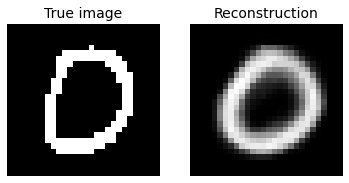

In [227]:
# Verify if there is some learning
fig, ax = plt.subplots(1,2)

test_sample = 10

# Prediction 
pred = tf.sigmoid(autoencoder(harencoder,hardecoder,x_test_images[test_sample:test_sample+1]))
pred = pred.numpy().squeeze()

ax[0].imshow(x_test_images[test_sample].squeeze(),cmap='gray')
ax[1].imshow(pred,cmap='gray')
ax[0].set_title('True image',fontsize=14)
ax[1].set_title('Reconstruction',fontsize=14);
ax[0].axis('off');
ax[1].axis('off');

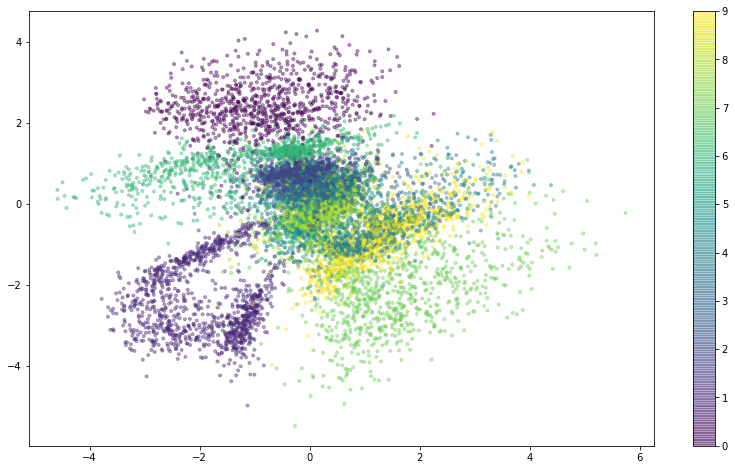

In [230]:
# display a 2D plot of the digit classes in the latent space
z_test = sample(*encode(varencoder,x_test_images[0:10000]))
plt.figure(figsize=(14, 8))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test[0:10000],
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [75]:
from scipy.stats import norm

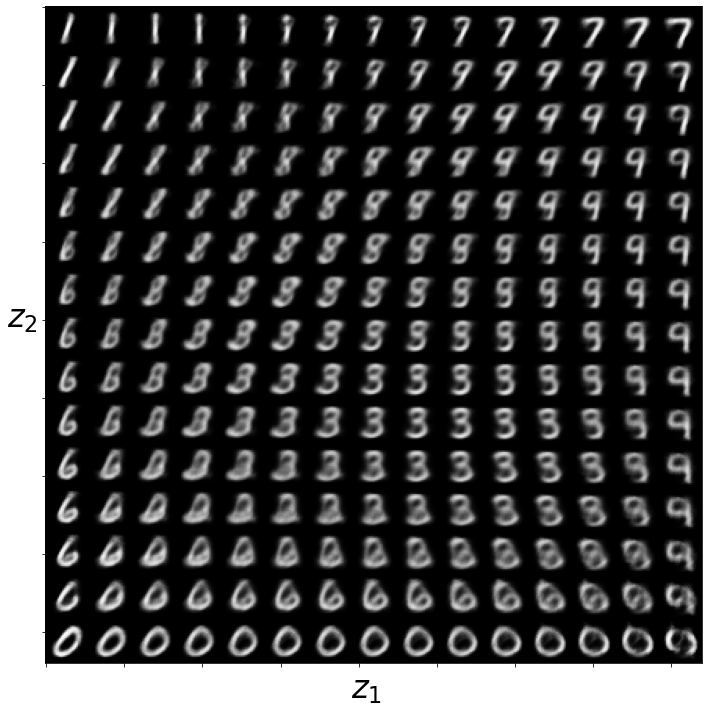

In [187]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

latent_dim = 2

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = tf.sigmoid(vardecoder.predict(z_grid.reshape(n*n, latent_dim))).numpy() \
                     .reshape(n, n, digit_size, digit_size)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
# ax.axis('off')
ax.set_xlabel('$z_1$  ', fontsize=32)
ax.set_ylabel('$z_2$   ', fontsize=32,rotation=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
plt.tight_layout()